Поскольку бейзлайн имеет врождённые пороки и с целью б**о**льшей чистоты сознания создаю ноутбук с нуля

# Иморты

In [1]:
import os
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
)
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from data_viz_functions import *


# Читаем данные

In [2]:
DATA_DIR = "kaggle/input/"
data = pd.read_csv(DATA_DIR + "train.csv")
df_test = pd.read_csv(DATA_DIR + "test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_train, df_validation = train_test_split(data, test_size=0.2, random_state=1337)

df_train["sample"] = 0  # на этом учимся
df_validation["sample"] = 1  # на этом проверяем
df_test["sample"] = 2  # на этом генерируем сабмишн

df_test["default"] = 0  # заполняем целевую переменную нулями там, где её нет

data = df_train.append(df_validation).append(df_test)

kaggle/input/sf-scoring.zip
kaggle/input/sample_submission.csv
kaggle/input/train.csv
kaggle/input/test.csv


In [3]:
data.shape

(110148, 20)

In [4]:
data["sample"].value_counts().to_frame()

,sample
0,59039
2,36349
1,14760


# Создаём списки с именами колонок

In [5]:
num_cols = ["age", "decline_app_cnt", "score_bki", "bki_request_cnt", "income"]
cat_cols = [
    "education",
    "first_time",
    "sna",
    "work_address",
    "home_address",
    "region_rating",
]
bin_cols = ["sex", "car", "car_type", "good_work", "foreign_passport"]


# Смотрим

In [6]:
describe_nums(data.drop(columns=["client_id", "score_bki", "sample"]))

,unique,n/a count,count,mean,std,min,25%,50%,75%,max
income,1207,0,110148.000000,41012.648537,45399.735051,1000.000000,20000.000000,30000.000000,48000.000000,1000000.000000
app_date,120,0,nan,nan,nan,nan,nan,nan,nan,nan
age,52,0,110148.000000,39.249410,11.518063,21.000000,30.000000,37.000000,48.000000,72.000000
bki_request_cnt,40,0,110148.000000,2.005002,2.266926,0.000000,0.000000,1.000000,3.000000,53.000000
decline_app_cnt,24,0,110148.000000,0.273205,0.799099,0.000000,0.000000,0.000000,0.000000,33.000000
region_rating,7,0,110148.000000,56.751189,13.065923,20.000000,50.000000,50.000000,60.000000,80.000000
education,5,478,nan,nan,nan,nan,nan,nan,nan,nan
sna,4,0,110148.000000,1.731588,1.122652,1.000000,1.000000,1.000000,2.000000,4.000000
first_time,4,0,110148.000000,2.765570,1.010151,1.000000,2.000000,3.000000,4.000000,4.000000
home_address,3,0,110148.000000,1.574945,0.527562,1.000000,1.000000,2.000000,2.000000,3.000000


В образовании есть пропуски, предположим, что это значит "без образования"

In [7]:
data.education.fillna("NA", inplace=True)

что за app_date?

In [8]:
data.app_date.value_counts().to_frame()

,app_date
18MAR2014,1491
19MAR2014,1363
17MAR2014,1350
31MAR2014,1317
07APR2014,1296
...,...
20APR2014,359
07JAN2014,349
03JAN2014,313
02JAN2014,204


обработаем как дату!

In [9]:
pd.to_datetime(data["app_date"]).value_counts().to_frame()

,app_date
2014-03-18,1491
2014-03-19,1363
2014-03-17,1350
2014-03-31,1317
2014-04-07,1296
...,...
2014-04-20,359
2014-01-07,349
2014-01-03,313
2014-01-02,204


In [10]:
data["app_date"] = pd.to_datetime(data["app_date"])
data["app_day"] = data.app_date.dt.day
data["app_week_day"] = data.app_date.dt.day_of_week
data["app_month"] = data.app_date.dt.month

In [11]:
del data["app_date"]

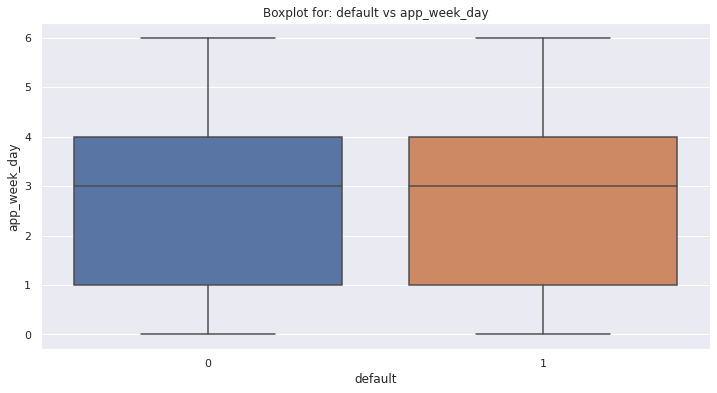

In [12]:
show_boxplots(data.query("sample < 2"), "default", "app_week_day")

<AxesSubplot:>

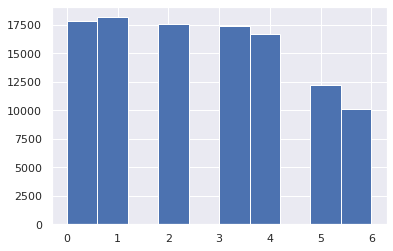

In [13]:
data.app_week_day.sort_values().hist()

## Смотрим числовые переменные

Unique values count: 52 
Q1: 30.0
Q3: 48.0
IQR: 18.0 
Outliers borders: [3.0, 75.0]


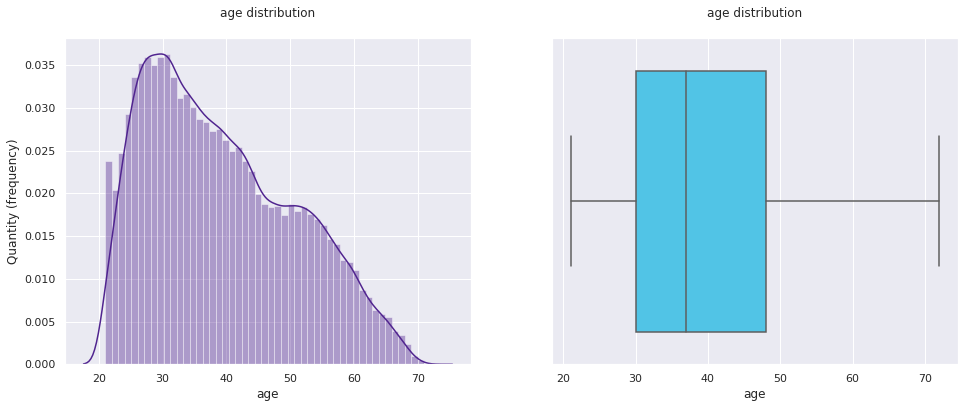

Unique values count: 24 
Q1: 0.0
Q3: 0.0
IQR: 0.0 
Outliers borders: [0.0, 0.0]


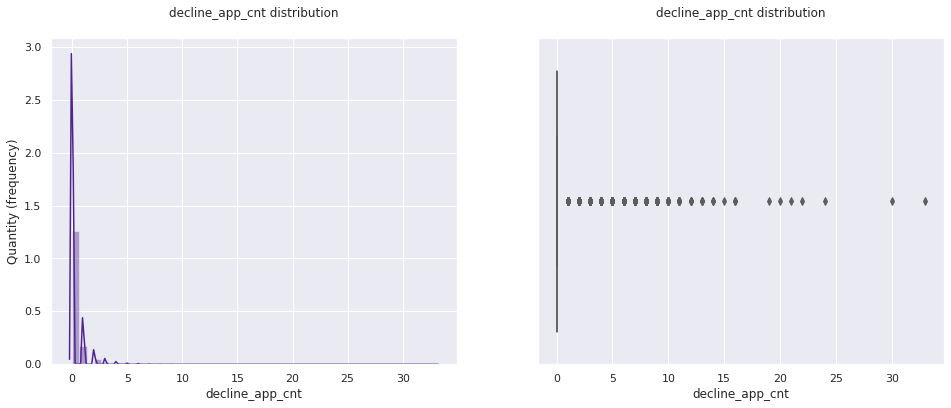

Unique values count: 102618 
Q1: -2.26044074
Q3: -1.5678840649999999
IQR: 0.6925566750000001 
Outliers borders: [-3.2992757525, -0.5290490524999998]


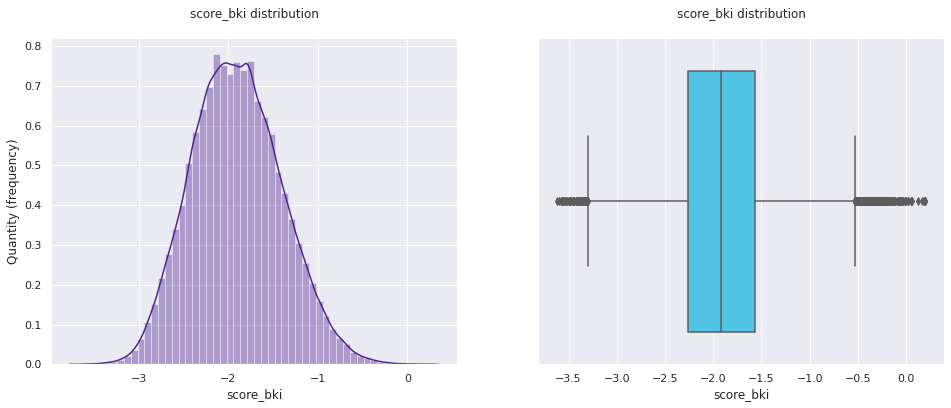

Unique values count: 40 
Q1: 0.0
Q3: 3.0
IQR: 3.0 
Outliers borders: [-4.5, 7.5]


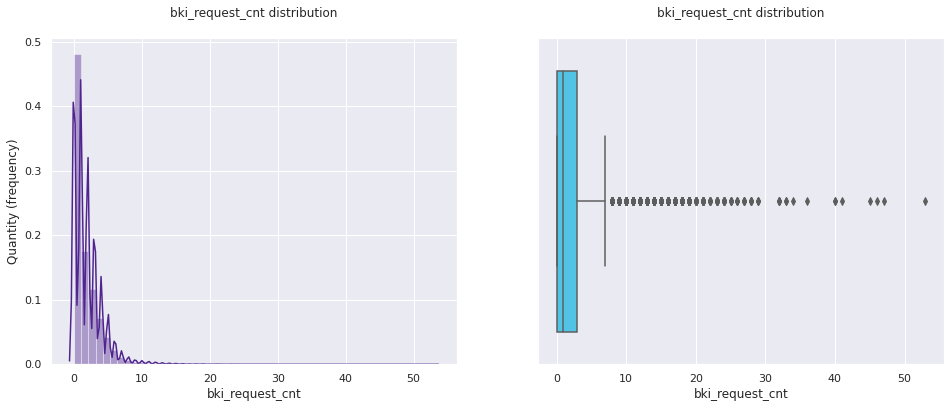

Unique values count: 1207 
Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Outliers borders: [-22000.0, 90000.0]


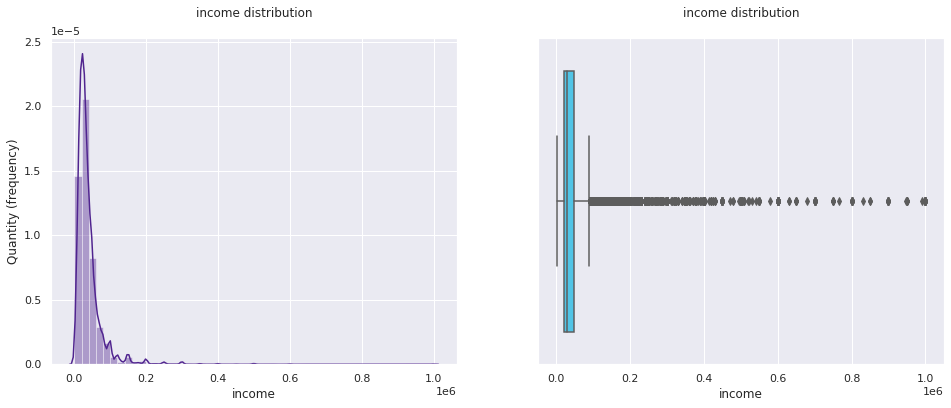

In [14]:
for n in num_cols:
    show_IQR(data[n])

Смещены все кроме score_bki, логорифмируем все, кроме score_bki

In [15]:
set(num_cols) - {"score_bki"}

{'age', 'bki_request_cnt', 'decline_app_cnt', 'income'}

Unique values count: 1207 
Q1: 9.90353755128617
Q3: 10.778977123006351
IQR: 0.8754395717201806 
Outliers borders: [8.590378193705899, 12.092136480586621]


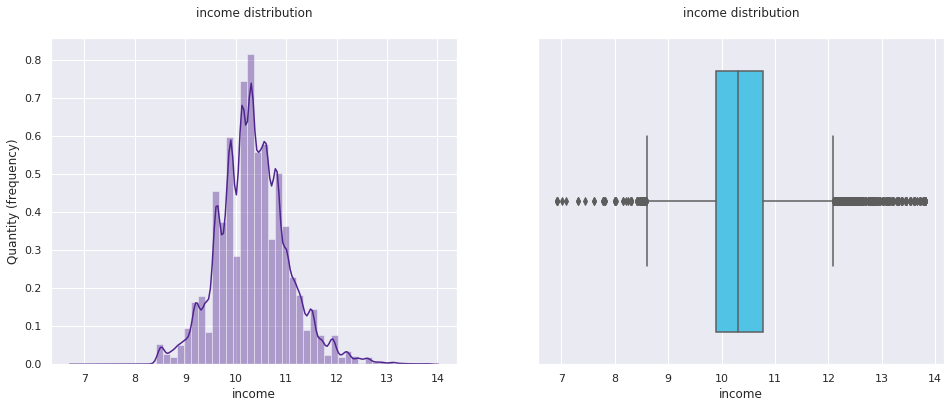

Unique values count: 52 
Q1: 3.4339872044851463
Q3: 3.8918202981106265
IQR: 0.4578330936254802 
Outliers borders: [2.7472375640469258, 4.5785699385488465]


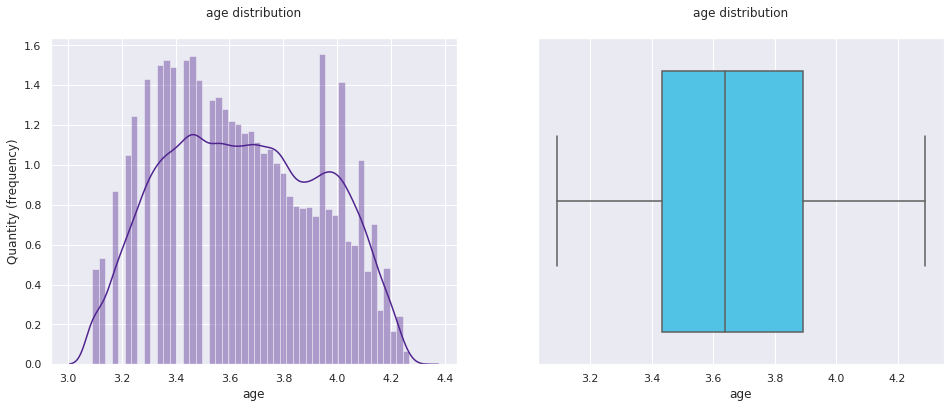

Unique values count: 24 
Q1: 0.0
Q3: 0.0
IQR: 0.0 
Outliers borders: [0.0, 0.0]


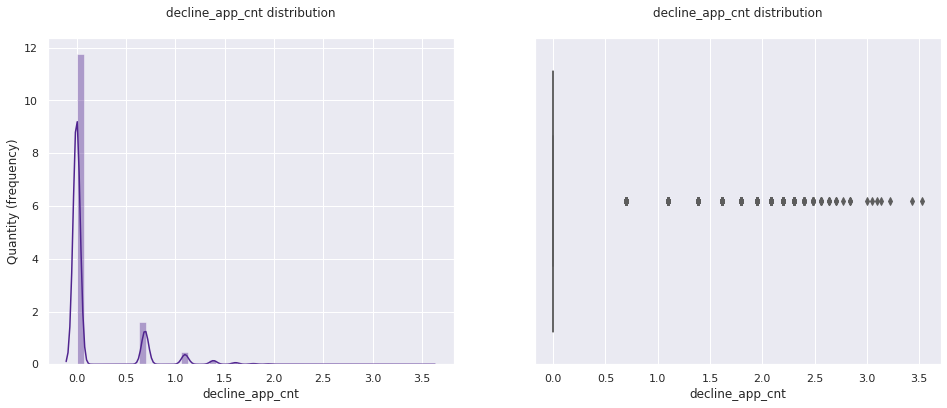

Unique values count: 40 
Q1: 0.0
Q3: 1.3862943611198906
IQR: 1.3862943611198906 
Outliers borders: [-2.0794415416798357, 3.465735902799726]


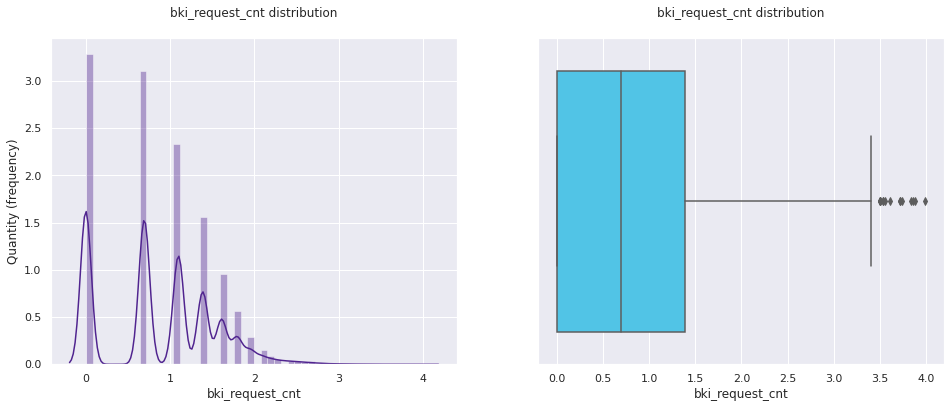

In [16]:
for n in set(num_cols) - {"score_bki"}:
    data[n] = data[n].apply(lambda w: np.log(w + 1))
    show_IQR(data[n])

Немного помогло

## распределение целевой переменной

<AxesSubplot:>

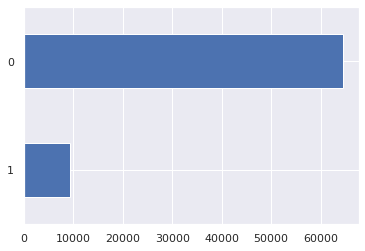

In [17]:
data.loc[data["sample"] < 2]["default"].value_counts(ascending=True).plot(kind="barh")


## корреляция и значимость признаков

In [18]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])

columns = ["first_time", "sna", "work_address", "home_address", "region_rating"]

for column in columns:
    data[column] = le.fit_transform(data[column])

In [19]:
data[num_cols] = RobustScaler().fit_transform(data[num_cols])

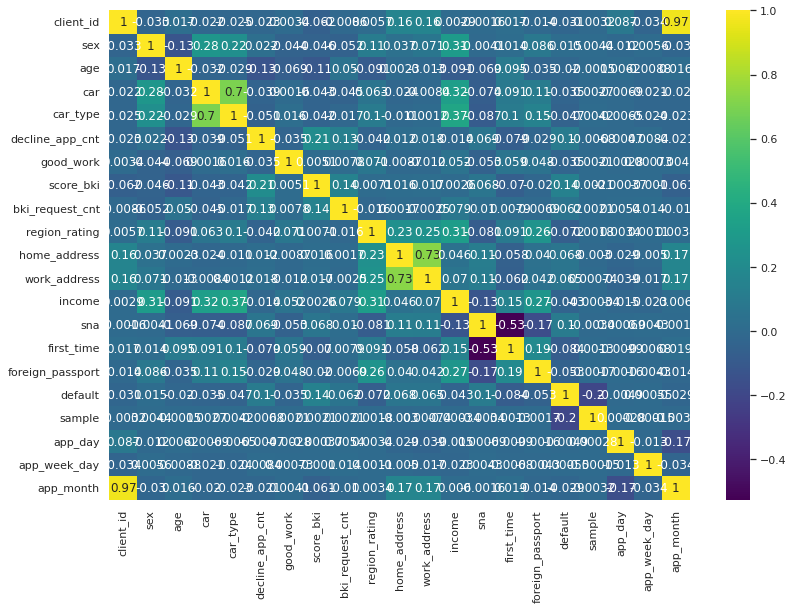

In [20]:
plt.subplots(figsize=(13, 9))
sns.heatmap(data.corr(), cmap="viridis", annot=True)
plt.show()

- **home_address** и **work_address** сильно скорреллированы
- **car** и **car_type** тоже ожидаемо близки
- **first_time** и **sna** под подозрением, хотя и не таким существенным

id кстати не нужны

In [21]:
ids = data["client_id"]  # сохраним на всякий пожарный

data.drop(
    ["client_id"],
    axis=1,
    inplace=True,
)


## Значимость переменных

<AxesSubplot:>

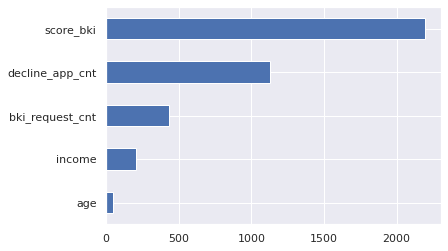

In [22]:
imp_num = pd.Series(f_classif(data[num_cols], data["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind="barh")

In [23]:
data["education"] = data["education"].map(data["education"].value_counts())


<AxesSubplot:>

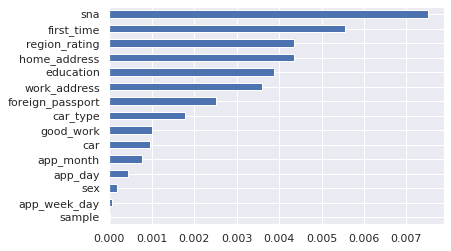

In [24]:

cols_to_plot = set(data.columns.tolist()) - set(num_cols + ["default"])

imp_cat = pd.Series(
    mutual_info_classif(
        data.query("sample < 2")[cols_to_plot],
        data.query("sample < 2")["default"],
        discrete_features=True,
    ),
    index=cols_to_plot,
)
imp_cat.sort_values().plot(kind="barh")

## get dummies

In [25]:
data_dummied = pd.get_dummies(
    data.fillna(0), columns=cat_cols + ["app_month", "app_week_day"], dummy_na=True
)

In [26]:
data = pd.get_dummies(
    data.fillna(0), columns=["education"], dummy_na=True
)

# Modelling

## Logistic Regression

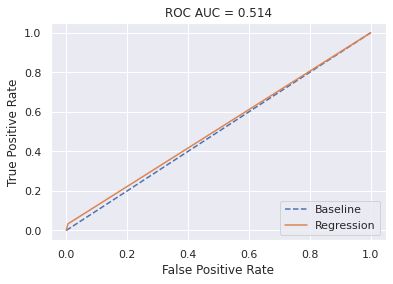

['              precision    recall  f1-score   support',
 '',
 '           0       0.88      0.99      0.93     12915',
 '           1       0.47      0.03      0.06      1845',
 '',
 '    accuracy                           0.87     14760',
 '   macro avg       0.67      0.51      0.50     14760',
 'weighted avg       0.83      0.87      0.82     14760',
 '']


In [27]:
show_classification_details(
    data_dummied.query("sample == 1")["default"],
    LogisticRegression()
    .fit(
        data_dummied.query("sample == 0").drop(columns=["default", "sample"]),
        data_dummied.query("sample == 0")["default"],
    )
    .predict(data_dummied.query("sample == 1").drop(columns=["default", "sample"])),
)


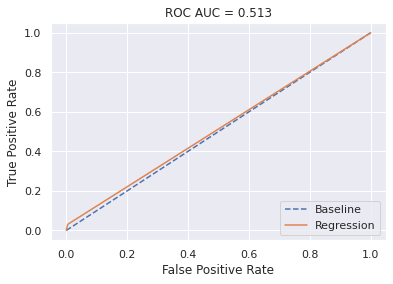

['              precision    recall  f1-score   support',
 '',
 '           0       0.88      1.00      0.93     12915',
 '           1       0.47      0.03      0.06      1845',
 '',
 '    accuracy                           0.87     14760',
 '   macro avg       0.67      0.51      0.50     14760',
 'weighted avg       0.83      0.87      0.82     14760',
 '']


In [28]:
train_cols = [
    "score_bki",
    "decline_app_cnt",
    "bki_request_cnt",
    "income",
    "sna",
    "first_time",
    "region_rating",
    "home_address",
    "foreign_passport",
    "car_type",
    "good_work",
    "age",
    "sex",
    "app_week_day",
    "app_month",
] + [c for c in data.columns if "education" in c]


show_classification_details(
    data.query("sample == 1")["default"],
    LogisticRegression()
    .fit(
        data.query("sample == 0")[train_cols],
        data.query("sample == 0")["default"],
    )
    .predict(data.query("sample == 1")[train_cols]),
)


берём версию со всеми категориальными dummy

сохраняем предобработанный датасет

In [29]:
data_dummied.to_pickle("preprocessed.pkl")